In [1]:
import math
import json
import numpy as np
import matplotlib.pyplot as plt

import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe
from openrtdynamics2.ORTDtoNumpy import ORTDtoNumpy

from vehicle_lib.vehicle_lib import *
import vehicle_lib.path_transformations as pt


In [2]:
Ts = 0.01

In [3]:
# load track data
with open("track_data/simple_track.json", "r") as read_file:
    track_data = json.load(read_file)


# Create a path transformer

In [4]:
path_transform = pt.LateralPathTransformer(wheelbase=3.0)

compiling system store_input_data (level 1)... 
compiling system tracker_loop (level 3)... 
compiling system Subsystem1000 (level 2)... 
compiling system controller (level 2)... 
compiling system simulation_model (level 2)... 
compiling system process_data (level 1)... 
compiling system simulation (level 0)... 
Generated code will be written to generated/tmp1 .


# Define profiles for the lateral distance to the original path

In [5]:
@ORTDtoNumpy()
def generate_one_dimensional_motion_trajectory(acceleration_input, Ts):

    # Delta_l_dotdot; the motion jerk is limited to +-1.0 m/s^3 
    acceleration     = dy.rate_limit(acceleration_input, Ts, lower_limit = -1.0, upper_limit = 1.0)

    # Delta_l_dot        
    velocity         = dy.euler_integrator(acceleration, Ts, 0)

    # Delta_l
    lateral_distance = dy.euler_integrator(velocity,     Ts, 0)

    return lateral_distance, velocity, acceleration



def generate_lateral_profile_1(Ts, T_phase1=1, T_phase2=3, T_phase3=1, T_phase4=3, T_phase5=1):
    """
        Generate a one-dimensional motion trajectory for a jerk-limited sidewards movement.
        
    """
    
    def ones_by_time(T):
        return np.ones( int(math.floor( T / Ts )) )


    
    lateral_distance, velocity, acceleration = generate_one_dimensional_motion_trajectory(
        np.concatenate((
            
            # phase 1: no movement 
            +0.0 * ones_by_time(T_phase1),
            
            # phase 2: movement into the positive direction
            #          divided into an accelerating phase,
            #          a phase of constant velocity, and finally
            #          a braking phase. The velocity is then zero.
            +1.0 * ones_by_time(T_phase2/3),
            +0.0 * ones_by_time(T_phase2/3),
            -1.0 * ones_by_time(T_phase2/3),
            
            # phase 3: no movement 
            +0.0 * ones_by_time(T_phase3),
            
            # phase 4: like phase 2, however, in the opposite direction 
            -1.0 * ones_by_time(T_phase4/3),
            +0.0 * ones_by_time(T_phase4/3),
            +1.0 * ones_by_time(T_phase4/3),
            
            # phase 5: no movement 
            +0.0 * ones_by_time(T_phase5)

        )),
        0.01
    )

    lateral_profile = {}
    lateral_profile['Delta_l_r_dotdot'] = acceleration
    lateral_profile['Delta_l_r_dot'] = velocity
    lateral_profile['Delta_l_r'] = lateral_distance

    # velocity of the vehicle
    lateral_profile['v'] = 5 * np.ones( len( lateral_profile['Delta_l_r'] ) )
    
    return lateral_profile

def plot_lateral_profile( lateral_profile ):
    """
        Show a profile for the lateral distance to the original path 
    """
    
    time = make_time(Ts, lateral_profile['Delta_l_r'])
    plt.figure(figsize=(12,3), dpi=100)
    plt.plot(time, lateral_profile['Delta_l_r'] )
    plt.plot(time, lateral_profile['Delta_l_r_dot'] )
    plt.plot(time, lateral_profile['Delta_l_r_dotdot'] )
    plt.legend(['intended lateral distance [$m$]', '1st derivative [$m/s$]', '2nd derivative [$m/s^s$]'])
    plt.xlabel('time [s]')
    plt.ylabel('lateral distance, velocity, acceleration')
    plt.show()



compiling system simulation (level 0)... 


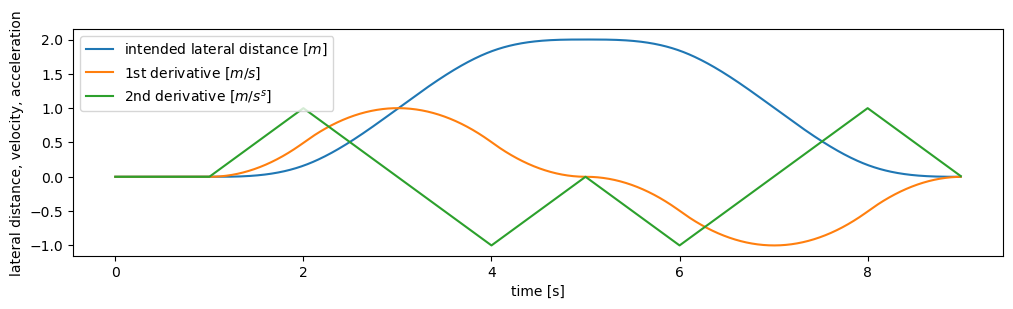

In [6]:
lateral_profile = generate_lateral_profile_1(Ts, T_phase1=1, T_phase2=3, T_phase3=1, T_phase4=3, T_phase5=1)

plot_lateral_profile(lateral_profile)

# Perform the transformation

Perform a lateral shift given the profile for the lateral distance to the original path.

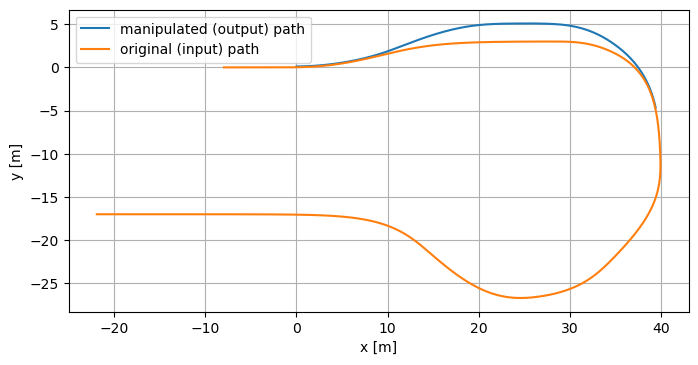

In [7]:
output_path = path_transform.run_lateral_path_transformer( track_data, lateral_profile )

plt.figure(figsize=(8,4), dpi=100)
plt.plot( output_path['X'], output_path['Y']+0.1 )
plt.plot( track_data['X'], track_data['Y'] )
plt.legend(['manipulated (output) path', 'original (input) path'])
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

The profiles for the curvature of the obtained path, and the steering angle and steering rate of a vehicle following the generatad path are given by:

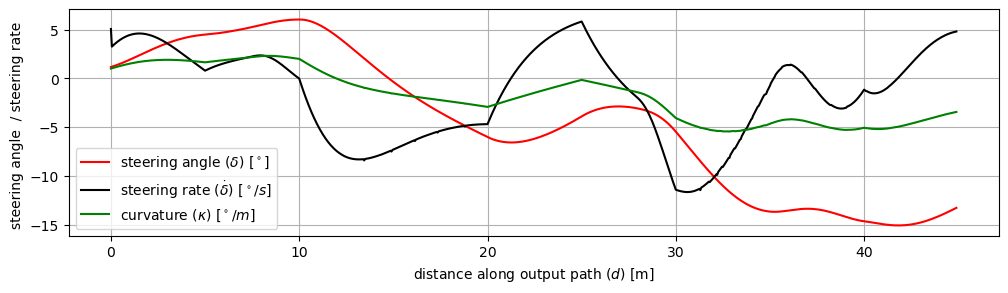

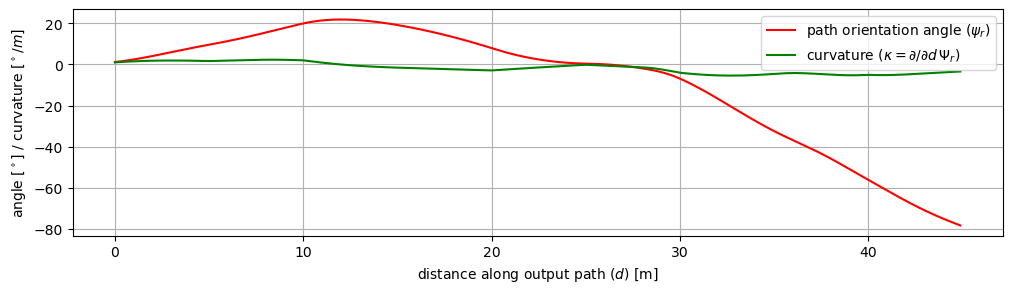

In [8]:
plot_path(output_path, show_xy=False)

# Parameter variation

Perform parameterized manipulations.
This might be an example on how to avoid an static obstacle using loop-based planning.

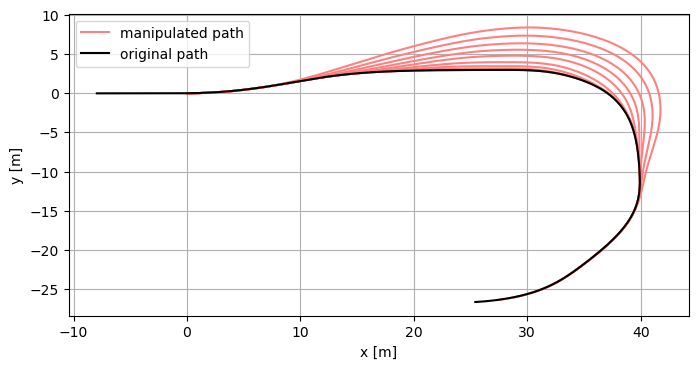

In [10]:
# compute multiple paths in a loop
output_paths = []

for duration_of_side_movement in np.linspace(0.3, 5, 10):

    lateral_profile = generate_lateral_profile_1(
        Ts, 
        T_phase1=4 - 0.6*duration_of_side_movement, 
        T_phase2=duration_of_side_movement, 
        T_phase3=1, 
        T_phase4=duration_of_side_movement,
        T_phase5=4
    )
    output_paths.append( path_transform.run_lateral_path_transformer( track_data, lateral_profile ) )



# plot
plt.figure(figsize=(8,4), dpi=100)

for output_path in output_paths:
    pi, = plt.plot( output_path['X'], output_path['Y'], color=(1.0, 0.5, 0.5) )
    
pi.set_label('manipulated path')

Nmax = 1700 # maximal amount of original path to show
p1, = plt.plot( track_data['X'][0:Nmax], track_data['Y'][0:Nmax], 'k' )
p1.set_label('original path')
plt.legend()

plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()